In [1]:
import numpy as np
import taichi as ti
import pyvista as pv

import k3d
from k3d.colormaps.basic_color_maps import Rainbow
from k3d.colormaps import paraview_color_maps

from IPython.display import clear_output
import time

[Taichi] version 1.0.3, llvm 10.0.0, commit fae94a21, win, python 3.8.8


In [2]:
def viewer_objs(particle_pos,world_bounds=None):
    #a simple viewer to visulize particles

    #Add points to plot
    num_pts = len(particle_pos)
    pkts = k3d.points(particle_pos.astype(np.float32))
    pkts.shader="mesh"

    #Add bounding box to plot
    if world_bounds is not None:
        lower,upper = np.array(world_bounds[0:3]),np.array(world_bounds[3:6])
        size = upper-lower
        cube_pv = pv.Cube(center=(lower+upper)/2.0,x_length=size[0],y_length=size[1],z_length=size[2])
        bbox = k3d.vtk_poly_data(cube_pv,
                                    color=0x000000,
                                    #opacity=0.5,
                                    wireframe=True)

    return pkts,bbox

def plot_particles(pos, world_bounds=[]):
    plot_pts,plot_box = viewer_objs(pos,world_bounds=world_bounds)
    plot_pts.point_size = 0.002
    plot_pts.attribute = pos[:,2]
    plot_pts.color_range=[0.0,np.max(plot_pts.attribute)]
    plot_pts.color_map = paraview_color_maps.Erdc_rainbow_dark

    plot = k3d.plot()
    plot += plot_pts
    plot += plot_box
    plot.display()

    return plot_pts

## Particle tracking to solve solute transport equation  (molecular diffusion)


Solute transport equation:

$$
\frac{\partial c_i}{\partial t}=-\mathbf{u}\cdot \nabla c_i+\nabla \cdot \left( D_m\nabla c_i \right) 
$$

Solve above equation in Lagrangian domain:
$$
\mathbf{x}\left( t^{n+1} \right) =\mathbf{x}\left( t^n \right) +\mathbf{u}\left( \mathbf{x}\left( t^n \right) ,t^n \right) \varDelta t+\xi \left( t \right) \sqrt{2D\varDelta t}
$$

## Square Duct Flow 3D - Hagen-Poiseuille flow
Analytical solution source: https://doi.org/10.1103/PhysRevE.71.057301

Example regards of Stokes problem:
$$
\nu \varDelta \mathbf{u}\left( x \right) +\nabla p=\mathbf{f}\left( x \right) ,   x\,\,\text{in }\varOmega \,\,
\\
\nabla \mathbf{u}\left( x \right) =\text{0,   }x\,\,\text{in }\varOmega 
$$

A exact solution of Stokes equation can be specificed as:
$$
\mathbf{u}=\left( u,0,0 \right) 
\\
u=-\frac{\varDelta p}{\mu L}\frac{4h^2}{\pi ^3}\sum_{n=1,3,5...}^{\infty}{\frac{1}{n^3}\left( 1-\frac{\cosh \left( n\pi x/h \right)}{\cosh \left( n\pi /2 \right)} \right) \sin \left( n\pi y/h \right)}
$$


The soluton domain is on a 3D square duct:
$$
\varOmega =\left[ -h/2,h/2 \right] \times \left[ 0,h \right] \times \left[ 0,L \right] 
$$

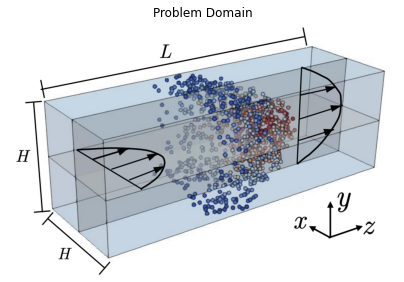

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Output Images
plt.figure(figsize=(7,5))
plt.imshow(mpimg.imread("imgs/domain.png"))
plt.axis('off')
plt.title("Problem Domain")
plt.show()

In [7]:
#Analytical solution source: https://doi.org/10.1103/PhysRevE.71.057301

mu=0.001072 #Pa s
dp=-16.34957100885819 #pressure drop Pa

def eval_vel_sqrduct3D(x,y,z=None):
    #velocity is the same along axial direction of z
    V=0.0
    for i in range(20):
        n=(2*i+1)
        V+=1/n**3*(1-np.cosh(n*np.pi*x/h)/np.cosh(n*np.pi/2))*np.sin(n*np.pi*y/h)
        
    vz=-dp/L/mu*4*h*h/np.pi**3*V
    return vz

print("max velocity=",abs(eval_vel_sqrduct3D(0,h/2)),'cm/s')

max velocity= 0.11235807882701149 cm/s


In [6]:
##https://www.jove.com/t/57205/the-diffusion-of-passive-tracers-in-laminar-shear-flow
print("Problem setup @ https://science.sciencemag.org/content/354/6317/1252")

# Length of the duct
L=100 #cm
# height of duct
h=0.1 #cm
# fluid viscosity
mu=0.001072 #Pa s
# pressure drop of square duct
dp=-16.34957100885819 #Pa
# dimension of the problem
Dim=3
# number of particles
NumOfParticles = 1000
# timestep for calculation, secs
timestep = 1e-2 
# total number of timestep
NumOfSteps = 50

#location and velocity of particles
pos = np.zeros([NumOfParticles,Dim],dtype=float)    
vel = np.zeros([NumOfParticles,Dim],dtype=float)    


def seedCube(cube_lower=[0.0,0.0,0.0],cube_size=[0.1,1.0,1.0]):
    #seeding particles within a cube
    for i in range(NumOfParticles):
        pos[i] = cube_lower + np.random.rand(Dim)*cube_size

Problem setup @ https://science.sciencemag.org/content/354/6317/1252


In [8]:
#check initial seeding
seedCube(cube_lower=[-h/2,0.0,0.0],cube_size=[h,h, 0.02])

#plot the particles
plot_pts=plot_particles(pos,world_bounds=[-h/2,0.0,0.0, h/2,h,L/300])

f:\Anaconda\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [9]:
def advection(dt):
    #fluid driven advection
    
    #compute velocity using an analytical solution
    vz = eval_vel_sqrduct3D(pos[:,0],pos[:,1])
    vel[:,0],vel[:,1],vel[:,2] = 0.0, 0.0, vz

    for i in range(NumOfParticles):
        pos[i] += dt*vel[i]

def dispersion(dt,diffusion_coef):
    #randowm walk dispersion 
    for i in range(NumOfParticles):
        pos[i] += np.random.normal(0,1,Dim)*np.sqrt(2.0*diffusion_coef*dt)

# initlize particles wihtin a cube region 
seedCube(cube_lower=[-h/2,0.0,0.0],cube_size=[h,h, 0.02])

# main simulation loop
for i in range(NumOfSteps):
    #advection
    advection(dt=timestep)

    #dispersion
    dispersion(dt=timestep,diffusion_coef=5.7e-6)

    #animation by coloring particles using velocity
    if i%1==0:
        plot_pts.positions = pos
        plot_pts.attribute = vel[:,2]
        plot_pts.color_range=[0.0,0.12]
        clear_output(wait=True)
        time.sleep(0.1)
        print("Timestep=",i)

Timestep= 49
